# Flux Balance Analysis (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import straindesign as sd
import pandas as pd
import matplotlib.pyplot as plt
import sys


source_dir = '../src'
sys.path.append(source_dir)
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from make_boxplot_grid import make_boxplot_grid
from is_active_in_fva import is_active_in_fva
from flux_prediction_scatterplot import flux_prediction_scatterplot


### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_2.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x15a845f60
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load 13C-MFA data

In [4]:
# load glucose 13C MFA data from ../data/13c_mfa/INCA_model_08302023_GR.xlsx
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_08302023_GR.xlsx', sheet_name='GSM Format')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0000,2.201100e-11,0.0000,0.0000,0.0000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-12.29,5.856500e+00,-23.5032,-2.2969,21.2063,-151.6655,1.094870e+01,-165.8804,-1.3939,164.4865


# Glucose

### Calculate glucose GSM pFBA solution

In [5]:
# update the media to minimal medium with glucose as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 100
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
glucose_fba_solution = sd.fba(model, constraints='EX_glc_e = -100.000', obj='biomass_C', obj_sense='maximize', pfba=1)
max_glucose_biomass_flux = glucose_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_glucose_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glucose_fba_solution.fluxes.values()])}')

# run pFBA FVA with 95% biomass flux constraint
glucose_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_glc_e = -100.000, biomass_C >= {0.95 * max_glucose_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in glucose_fva_95_solution.iterrows()])}')

# run pFBA FVA with 10% biomass flux constraint
glucose_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_glc_e = -100.000, biomass_C >= {0.10 * max_glucose_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in glucose_fva_10_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glucose_fba_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': flux,
    '95_LB': glucose_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': glucose_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': glucose_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': glucose_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glucose_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glucose_gsm_fba_df = glucose_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glucose_gsm_fba_df = glucose_gsm_fba_df.drop(columns=['absolute_flux'])

glucose_gsm_fba_df.head()

100 EX_glc_e
10000 EX_h2o_e
10000 EX_h_e
10000 EX_nh4_e
10000 EX_o2_e
10000 EX_pi_e
10000 EX_so4_e
Maximum biomass flux: 11.398166174414.
The number of active reactions in pFBA: 291
The number of active reactions in 95% biomass FVA: 716
The number of active reactions in 10% biomass FVA: 719


,reaction_id,reaction_name,full_reaction,flux,95_LB,95_UB,10_LB,10_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-560.394053,-1000.000000,-468.079591,-1000.000000,801.124207
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],341.609652,296.127430,429.646712,0.000000,1000.000000
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],335.476108,-12.909865,737.755384,-1000.000000,1000.000000
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,326.533474,285.895834,427.281790,0.000000,1000.000000
421,EX_h2o_e,H2O exchange,h2o[e] <=>,325.265198,303.726730,363.769693,-42.494019,912.618217


### Add glucose pFBA columns to 13C-MFA data

In [6]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_gsm_fba_df, 'glucose_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_gsm_fba_df, 'glucose', 'pFBA')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB,glucose_pFBA_flux,glucose_pFBA_95_LB,glucose_pFBA_95_UB,glucose_pFBA_10_LB,glucose_pFBA_10_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-6.745562,0.0,-107.71684,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,100.0000,2.201100e-11,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-151.6655,1.094870e+01,-165.8804,-1.3939,164.4865,35.574485,-57.432341,88.758672,-460.442086,98.816702


### Plot glucose MFA vs pFBA boxplots

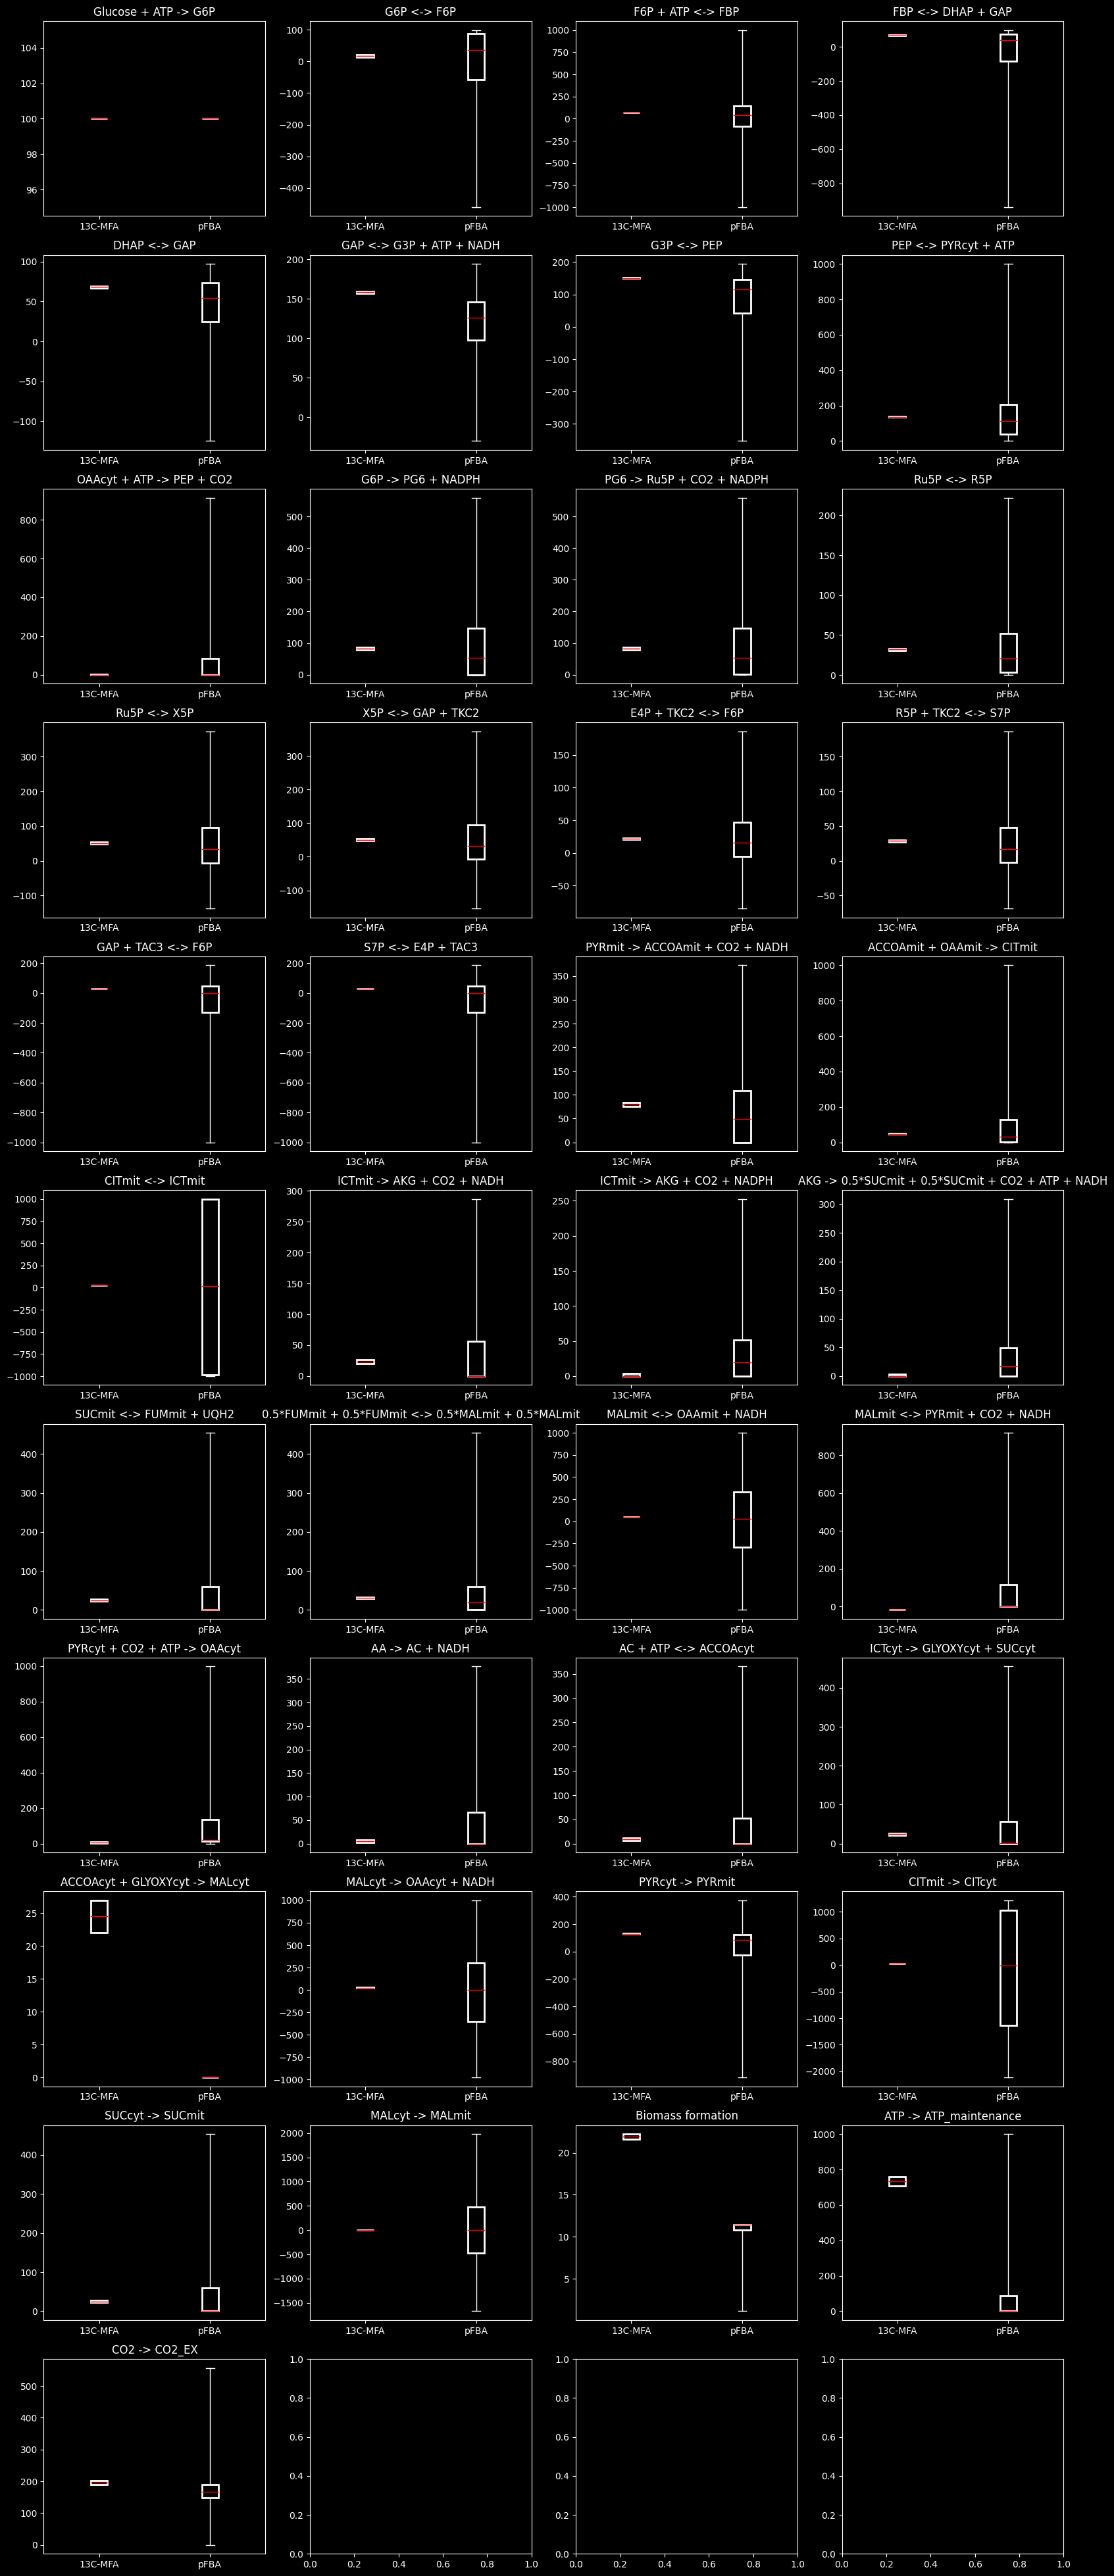

In [7]:
make_boxplot_grid(central_rxn_df, 'glucose', 'pFBA')

# Glycerol

### Calculate glycerol GSM pFBA solution

In [8]:
# update the media to minimal medium with glycerol as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 100
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
glycerol_fba_solution = sd.fba(model, constraints='EX_glyc_e = -100.000', obj='biomass_C', obj_sense='maximize', pfba=1)
max_glycerol_biomass_flux = glycerol_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_glycerol_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glycerol_fba_solution.fluxes.values()])}')

# run pFBA FVA with 95% biomass flux constraint
glycerol_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_glyc_e = -100.000, biomass_C >= {0.95 * max_glycerol_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in glycerol_fva_95_solution.iterrows()])}')

# run pFBA FVA with 10% biomass flux constraint
glycerol_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_glyc_e = -100.000, biomass_C >= {0.10 * max_glycerol_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in glycerol_fva_10_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glycerol_fba_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': flux,
    '95_LB': glycerol_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': glycerol_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': glycerol_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': glycerol_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glycerol_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glycerol_gsm_fba_df = glycerol_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glycerol_gsm_fba_df = glycerol_gsm_fba_df.drop(columns=['absolute_flux'])

glycerol_gsm_fba_df.head()

100 EX_glyc_e
10000 EX_h2o_e
10000 EX_h_e
10000 EX_nh4_e
10000 EX_o2_e
10000 EX_pi_e
10000 EX_so4_e
Maximum biomass flux: 4.66984653044.
The number of active reactions in pFBA: 272
The number of active reactions in 95% biomass FVA: 714
The number of active reactions in 10% biomass FVA: 714


,reaction_id,reaction_name,full_reaction,flux,95_LB,95_UB,10_LB,10_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-574.850423,-1000.000000,-532.829557,-1000.000000,59.962373
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-354.104943,-373.593657,-335.098326,-643.885965,-125.105429
421,EX_h2o_e,H2O exchange,h2o[e] <=>,354.104943,335.098326,373.593657,125.105429,643.885965
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],315.462030,124.790438,577.484730,-327.808422,1000.000000
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,313.155793,293.680292,348.636928,0.000000,850.318658


### Add glycerol pFBA columns to 13C-MFA data

In [9]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, 'glycerol_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, 'glycerol', 'pFBA')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_pFBA_flux,glucose_pFBA_95_LB,glucose_pFBA_95_UB,glucose_pFBA_10_LB,glucose_pFBA_10_UB,glycerol_pFBA_flux,glycerol_pFBA_95_LB,glycerol_pFBA_95_UB,glycerol_pFBA_10_LB,glycerol_pFBA_10_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-6.745562,0.0,-107.71684,0.0,100.0,100.0,100.0,100.0,100.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,35.574485,-57.432341,88.758672,-460.442086,98.816702,-27.963948,-46.039863,-4.60559,-175.003114,-0.484799


### Plot glycerol MFA vs pFBA boxplots

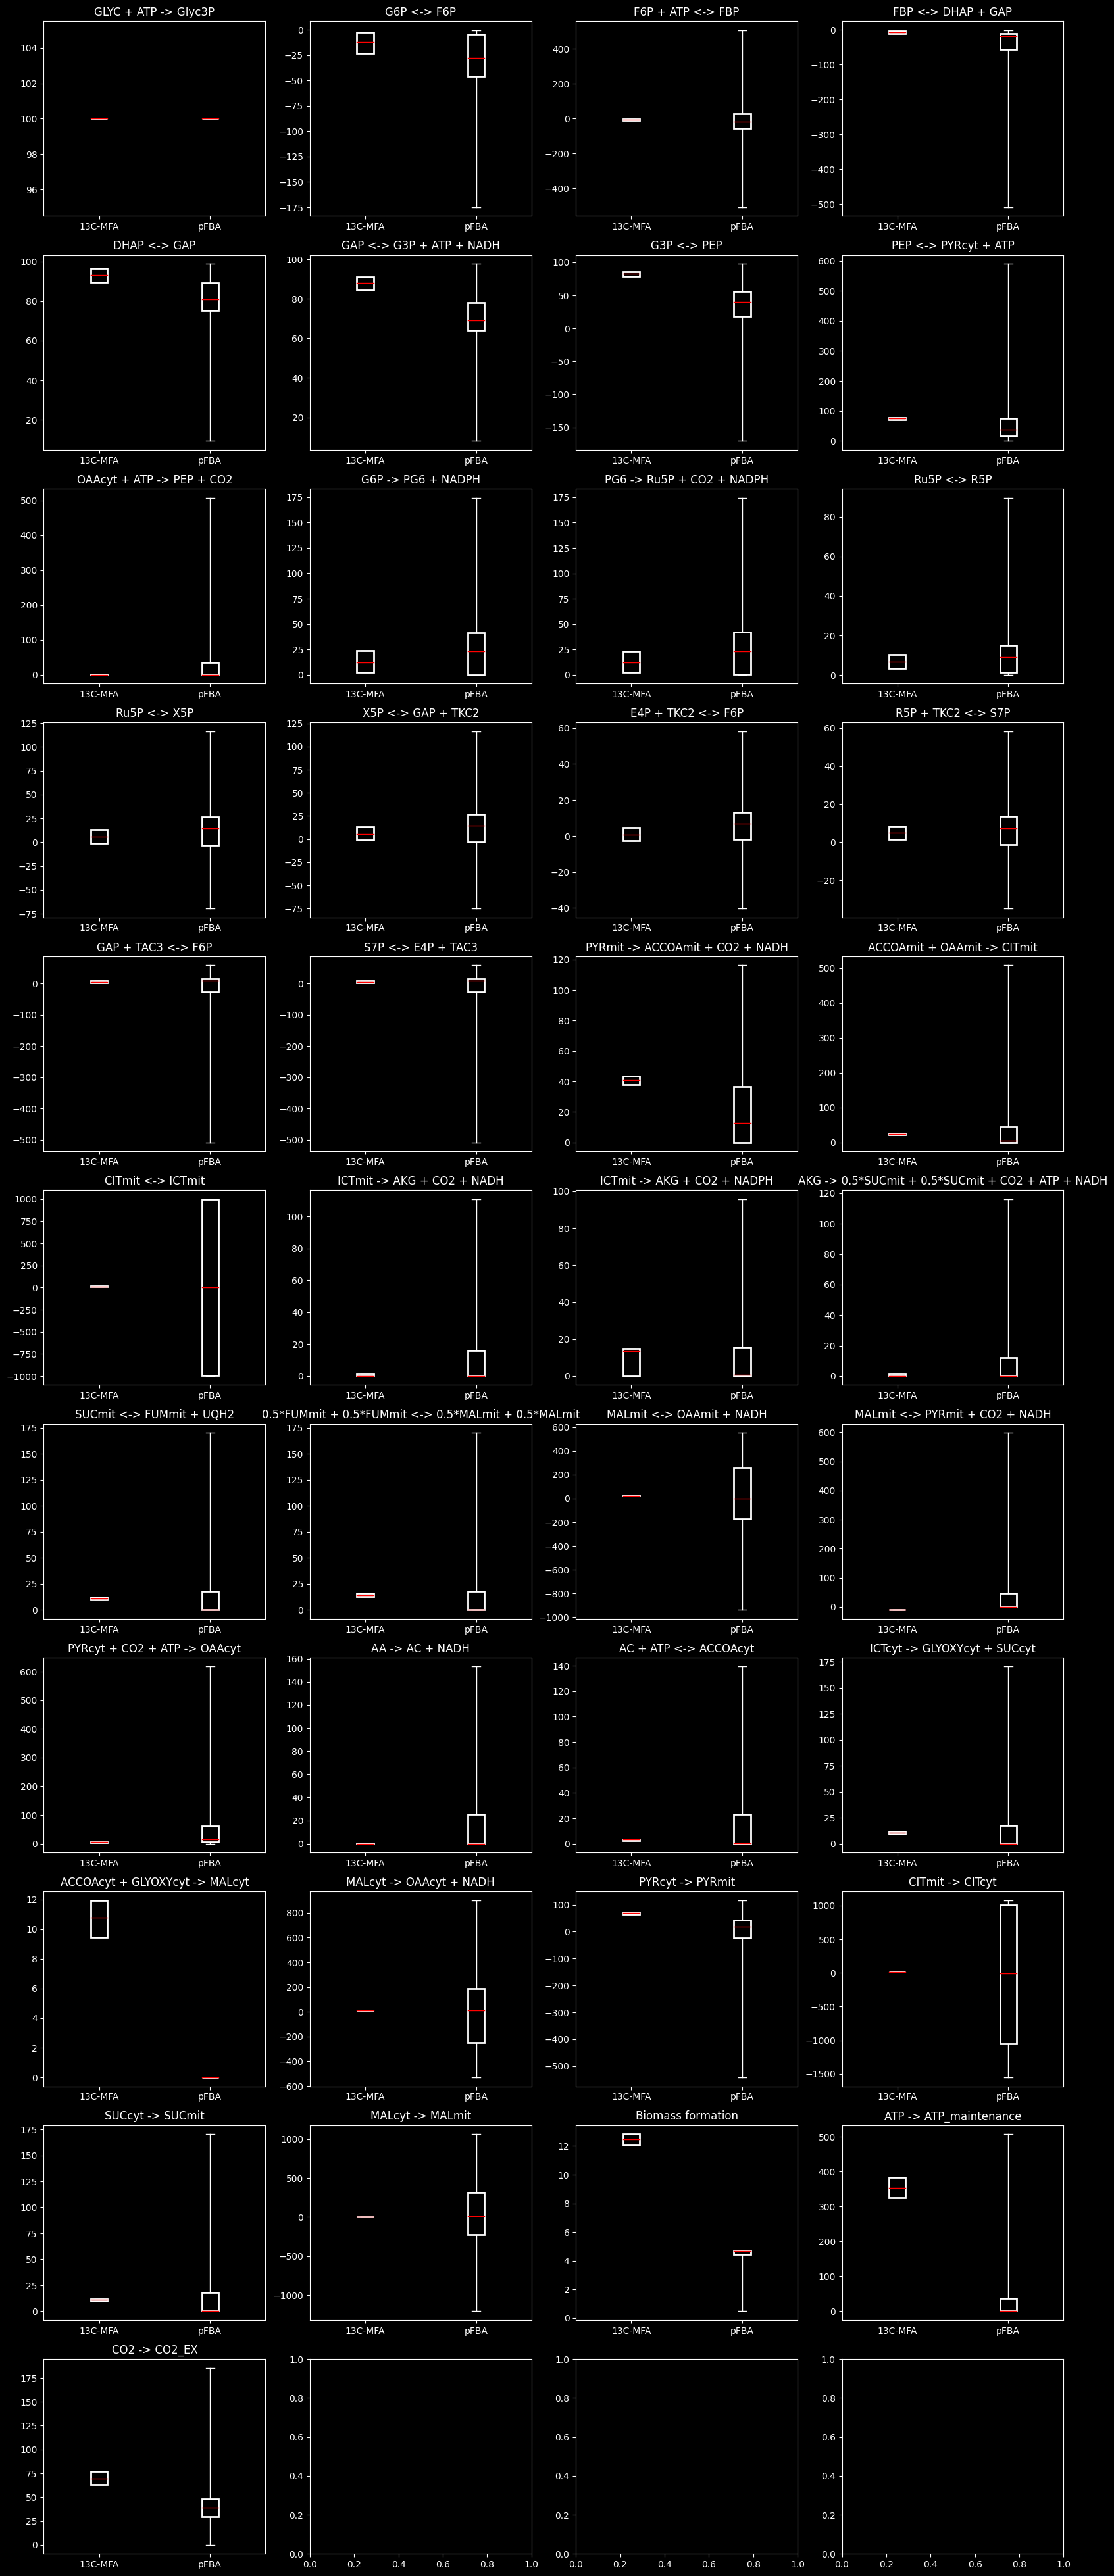

In [10]:
# make_boxplot_grid(central_rxn_df, 'glycerol')
make_boxplot_grid(central_rxn_df, 'glycerol', 'pFBA')

# Oleic Acid

### Calculate oleic acid GSM pFBA solution

In [11]:
# update the media to minimal medium with oleic_acid as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 10 # this is prevent overflow
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
oleic_acid_fba_solution = sd.fba(model, constraints='EX_ocdcea_e = -10', obj='biomass_C', obj_sense='maximize', pfba=1)
max_oleic_acid_biomass_flux = oleic_acid_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_oleic_acid_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in oleic_acid_fba_solution.fluxes.values()])}')

# run pFBA FVA with 95% biomass flux constraint
oleic_acid_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_ocdcea_e = -10, biomass_C >= {0.95 * max_oleic_acid_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in oleic_acid_fva_95_solution.iterrows()])}')

# run pFBA FVA with 10% biomass flux constraint
oleic_acid_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_ocdcea_e = -10, biomass_C >= {0.10 * max_oleic_acid_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in oleic_acid_fva_10_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in oleic_acid_fba_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': 10 * flux,
    '95_LB': 10 * oleic_acid_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': 10 * oleic_acid_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': 10 * oleic_acid_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': 10 * oleic_acid_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': 10 * abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
oleic_acid_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.drop(columns=['absolute_flux'])

oleic_acid_gsm_fba_df.head()

10000 EX_h2o_e
10000 EX_h_e
10000 EX_nh4_e
10000 EX_o2_e
10 EX_ocdcea_e
10000 EX_pi_e
10000 EX_so4_e
Maximum biomass flux: 2.957316982462.
The number of active reactions in pFBA: 284
The number of active reactions in 95% biomass FVA: 715
The number of active reactions in 10% biomass FVA: 716


,reaction_id,reaction_name,full_reaction,flux,95_LB,95_UB,10_LB,10_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3584.266821,-10000.000000,-2810.372360,-10000.000000,1740.850833
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2269.151708,2080.694123,2496.142355,0.000000,6004.652704
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2265.438412,709.741825,3563.272440,-2441.269928,9064.531657
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2265.438412,2075.821794,2645.854948,491.837852,6661.437214
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,2053.128358,1893.805273,2170.472301,97.128172,4085.905939


### Add oleic acid pFBA columns to 13C-MFA data

In [12]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, 'oleic_acid_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, 'oleic_acid', 'pFBA')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_pFBA_flux,glycerol_pFBA_95_LB,glycerol_pFBA_95_UB,glycerol_pFBA_10_LB,glycerol_pFBA_10_UB,oleic_acid_pFBA_flux,oleic_acid_pFBA_95_LB,oleic_acid_pFBA_95_UB,oleic_acid_pFBA_10_LB,oleic_acid_pFBA_10_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,100.0,100.0,0.0,-16.938776,0.0,-247.590694,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-27.963948,-46.039863,-4.60559,-175.003114,-0.484799,-30.701311,-374.965718,-29.166245,-1158.032011,-3.070131


### Plot oleic acid MFA vs pFBA boxplots

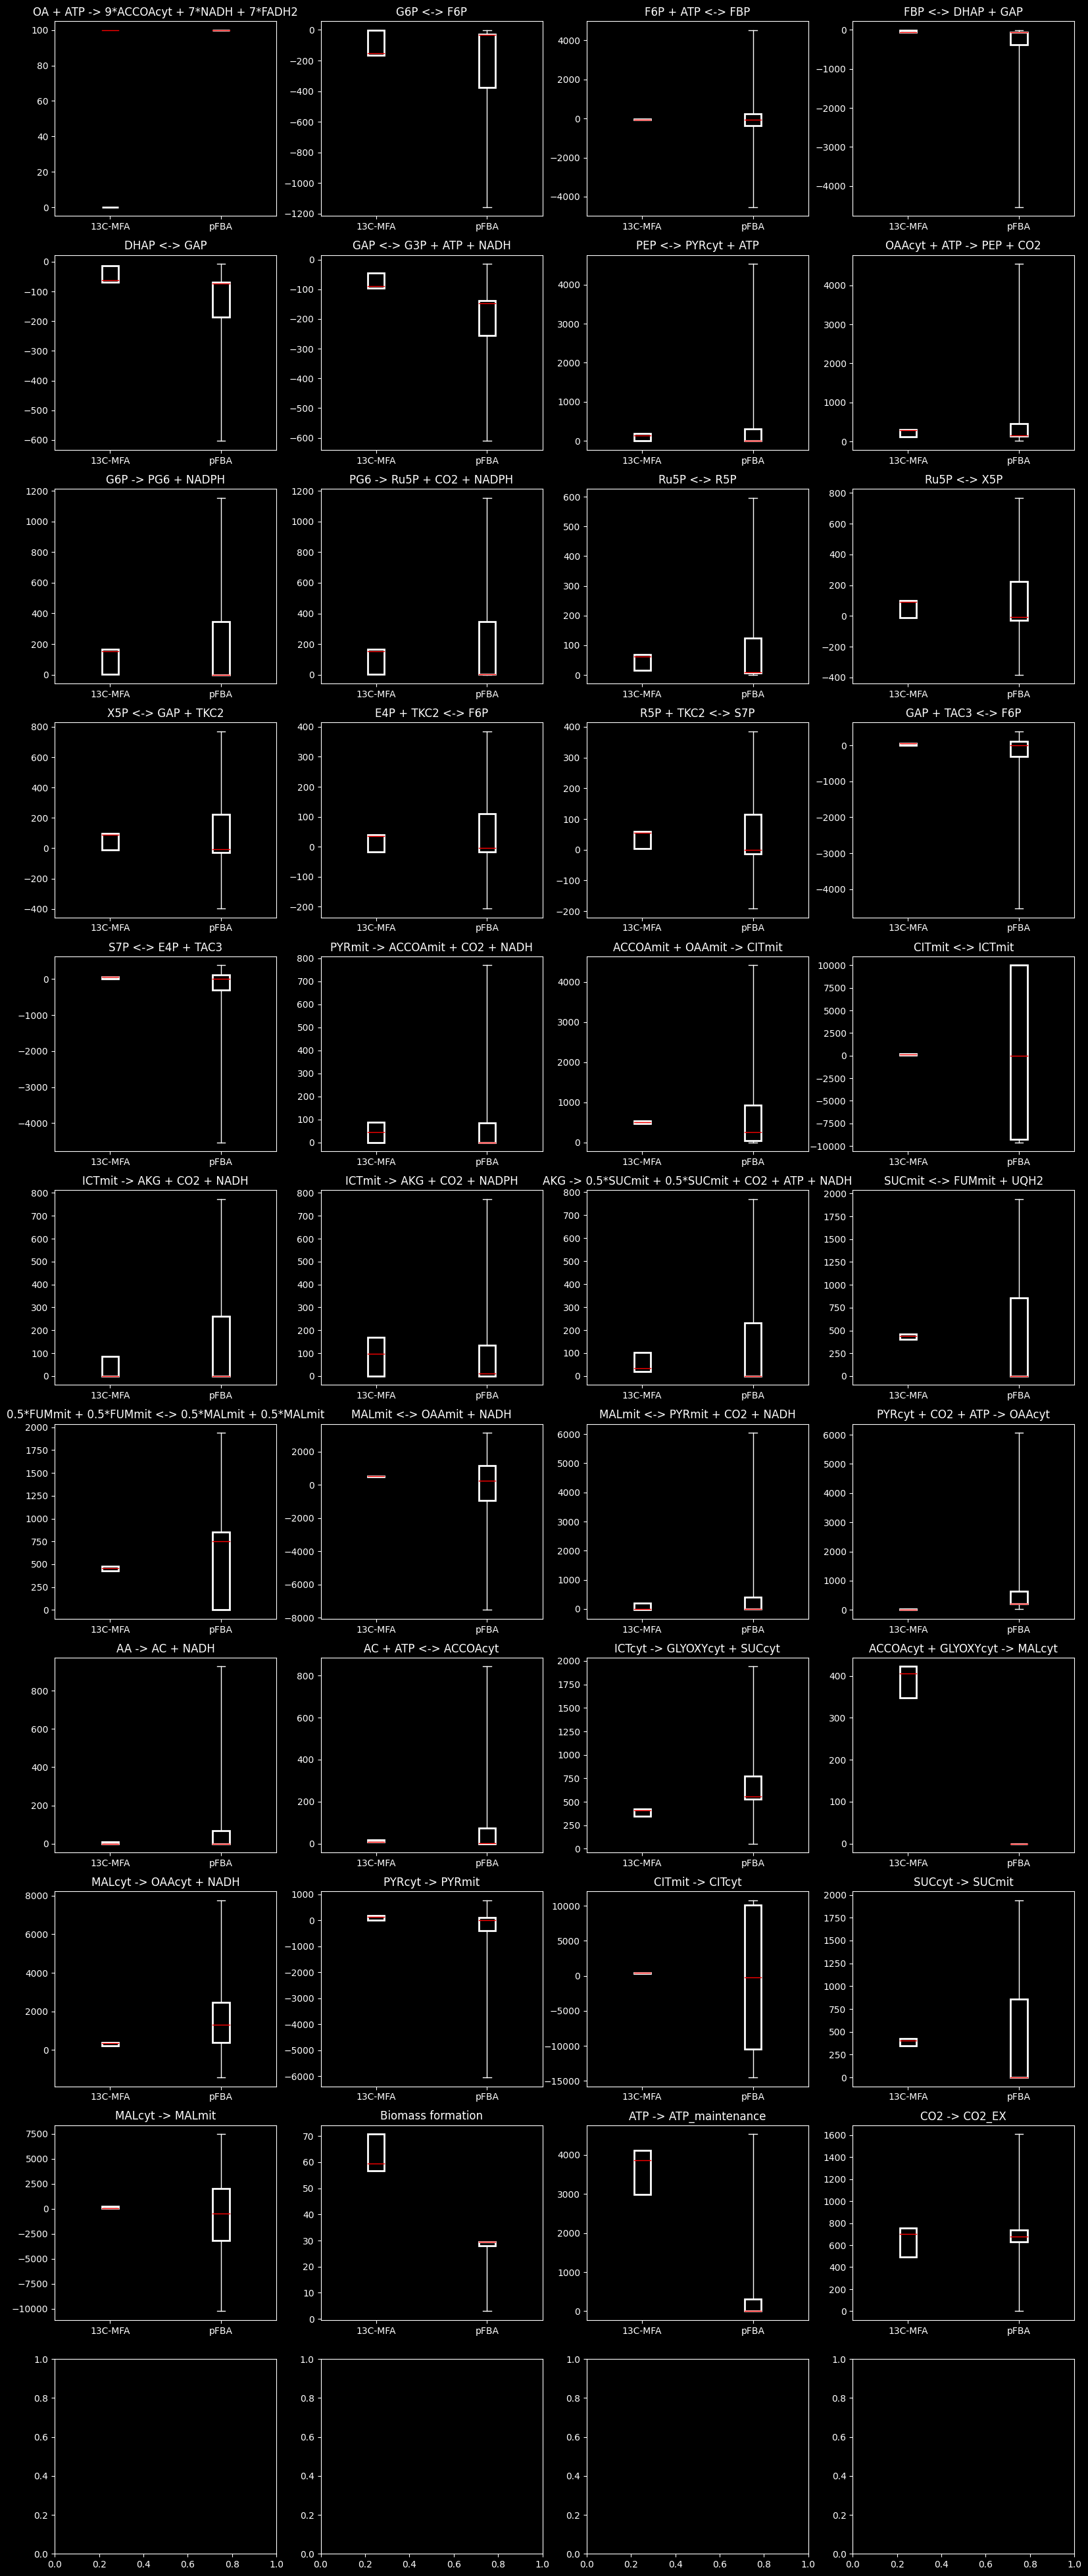

In [13]:
make_boxplot_grid(central_rxn_df, 'oleic_acid', 'pFBA')

# Save Data

### Save central flux data with pFBA data added

In [14]:
# save the dataframe to a csv file
central_rxn_df.to_csv('../results/central_fluxes/pfba.csv', index=False, encoding='utf-8-sig')